In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define the sample size
n_samples = 4000

# Generate sleep hours (1-24) - MORE EXTREME DISTRIBUTION
sleep_hours = np.round(np.random.normal(7, 2.5, n_samples).clip(1, 24), 1)  # Wider std dev

# Generate body temperature - SIMPLIFY CATEGORIES
body_temp_categories = ['Normal', 'Not Normal']  # Simplified
body_temp_probs = [0.7, 0.3]
body_temperature = np.random.choice(body_temp_categories, n_samples, p=body_temp_probs)

# Generate noise levels
noise_categories = ['Quiet', 'Moderate', 'Noisy']
noise_probs = [0.3, 0.4, 0.3]
noise_levels = np.random.choice(noise_categories, n_samples, p=noise_probs)

# Generate working hours - INCREASE VARIANCE
work_hours_categories = ['Short Day', 'Normal Day', 'Long Day', 'Extreme Overtime']
work_hours_probs = [0.15, 0.4, 0.3, 0.15]  # More extreme distribution
working_hours = np.random.choice(work_hours_categories, n_samples, p=work_hours_probs)

# Generate working area temperature - SIMPLIFY
work_temp_categories = ['Comfortable', 'Uncomfortable']  # Simplified
work_temp_probs = [0.6, 0.4]
working_area_temperature = np.random.choice(work_temp_categories, n_samples, p=work_temp_probs)

# Generate workload - MAKE MORE EXTREME
workload_categories = ['Light', 'Normal', 'Heavy']  # Simplified
workload_probs = [0.25, 0.5, 0.25]
workload = np.random.choice(workload_categories, n_samples, p=workload_probs)

# Generate type of work - SIMPLIFY
work_type_categories = ['Easy', 'Demanding']  # Simplified
work_type_probs = [0.6, 0.4]
type_of_work = np.random.choice(work_type_categories, n_samples, p=work_type_probs)

# Generate working shift
work_shift_categories = ['Day shift', 'Night shift']
work_shift_probs = [0.7, 0.3]
working_shift = np.random.choice(work_shift_categories, n_samples, p=work_shift_probs)

# DRAMATICALLY IMPROVED: Function to calculate stress level with very strong correlations
def calculate_stress_level(sleep, body_temp, noise, work_hours, work_temp, work_load, work_type, shift):
    # Initial score
    stress_score = 0

    # MAIN DRIVERS OF STRESS - These will be highly predictive

    # Sleep hours effect - QUADRATIC RELATIONSHIP
    # Less sleep = exponentially more stress
    sleep_stress = max(0, 25 - 3 * sleep + 0.15 * (sleep - 7)**2)
    stress_score += sleep_stress

    # Workload is now a primary driver
    if work_load == 'Light':
        stress_score += 0
    elif work_load == 'Normal':
        stress_score += 8
    elif work_load == 'Heavy':
        stress_score += 18

    # Working hours effect - Much stronger impact
    if work_hours == 'Short Day':
        stress_score += 0
    elif work_hours == 'Normal Day':
        stress_score += 5
    elif work_hours == 'Long Day':
        stress_score += 12
    elif work_hours == 'Extreme Overtime':
        stress_score += 20

    # SECONDARY FACTORS - Still important

    # Body temperature effect
    if body_temp == 'Not Normal':
        stress_score += 7

    # Noise levels effect
    if noise == 'Moderate':
        stress_score += 3
    elif noise == 'Noisy':
        stress_score += 8

    # Working area temperature effect
    if work_temp == 'Uncomfortable':
        stress_score += 6

    # Type of work effect
    if work_type == 'Demanding':
        stress_score += 8

    # Working shift effect
    if shift == 'Night shift':
        stress_score += 9

    # INTERACTION EFFECTS - Key for high accuracy

    # Bad combination: Noisy environment + Night shift
    if noise == 'Noisy' and shift == 'Night shift':
        stress_score += 8

    # Bad combination: Heavy workload + Long hours
    if work_load == 'Heavy' and (work_hours == 'Long Day' or work_hours == 'Extreme Overtime'):
        stress_score += 10

    # Bad combination: Uncomfortable temperature + Demanding work
    if work_temp == 'Uncomfortable' and work_type == 'Demanding':
        stress_score += 7

    # Bad combination: Not Normal body temperature + Night shift
    if body_temp == 'Not Normal' and shift == 'Night shift':
        stress_score += 6

    # MINIMAL randomness (almost deterministic)
    stress_score += np.random.normal(0, 0.05)  # Extremely small noise

    # Categorize stress level - CLEARER BOUNDARIES
    if stress_score < 15:
        return 'Low'
    elif stress_score < 30:
        return 'Medium'
    elif stress_score < 45:
        return 'High'
    else:
        return 'Extremely High'

# Calculate stress levels
stress_levels = []
for i in range(n_samples):
    stress_level = calculate_stress_level(
        sleep_hours[i],
        body_temperature[i],
        noise_levels[i],
        working_hours[i],
        working_area_temperature[i],
        workload[i],
        type_of_work[i],
        working_shift[i]
    )
    stress_levels.append(stress_level)

# Create DataFrame
data = {
    'sleep_hours': sleep_hours,
    'body_temperature': body_temperature,
    'noise_levels': noise_levels,
    'working_hours': working_hours,
    'working_area_temperature': working_area_temperature,
    'workload': workload,
    'type_of_work': type_of_work,
    'working_shift': working_shift,
    'calculated_stress_level': stress_levels
}

df = pd.DataFrame(data)

# CREATE POWERFUL DERIVED FEATURES
# Sleep-related features
df['sleep_squared'] = df['sleep_hours'] ** 2
df['sleep_low'] = (df['sleep_hours'] < 6).astype(int)
df['sleep_optimal'] = ((df['sleep_hours'] >= 7) & (df['sleep_hours'] <= 8)).astype(int)

# Complex interaction features
df['night_noisy'] = ((df['working_shift'] == 'Night shift') & (df['noise_levels'] == 'Noisy')).astype(int)
df['bad_conditions'] = ((df['working_area_temperature'] == 'Uncomfortable') &
                       (df['type_of_work'] == 'Demanding')).astype(int)
df['overworked'] = ((df['workload'] == 'Heavy') &
                   (df['working_hours'].isin(['Long Day', 'Extreme Overtime']))).astype(int)

# Target encoding for better ML performance
df['high_stress_binary'] = df['calculated_stress_level'].apply(lambda x: 1 if x in ['High', 'Extremely High'] else 0)

# Save to CSV
df.to_csv('workplace_stress_dataset_4k_dramatically_improved.csv', index=False)

print(f"Dataset with {n_samples} samples generated and saved to 'workplace_stress_dataset_4k_dramatically_improved.csv'")

# Show dataset distribution
print("\nStress Level Distribution:")
print(df['calculated_stress_level'].value_counts())

# BASIC ML TEST TO VERIFY HIGH ACCURACY POTENTIAL
print("\nPerforming a quick ML test to estimate potential accuracy:\n")

# Encode categorical features
categorical_cols = ['body_temperature', 'noise_levels', 'working_hours',
                   'working_area_temperature', 'workload', 'type_of_work', 'working_shift']

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])

# Prepare features and target
feature_cols = ['sleep_hours', 'sleep_squared', 'sleep_low', 'sleep_optimal',
                'night_noisy', 'bad_conditions', 'overworked'] + [col + '_encoded' for col in categorical_cols]

X = df[feature_cols]
y = df['calculated_stress_level']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a simple Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Estimated ML Accuracy: {accuracy:.4f}")
print("\nFeature Importances:")
for i, feature in enumerate(feature_cols):
    print(f"{feature}: {model.feature_importances_[i]:.4f}")

# Correlation analysis
print("\nCorrelation with high stress (binary):")
correlation_cols = ['sleep_hours', 'sleep_squared', 'sleep_low', 'sleep_optimal',
                   'night_noisy', 'bad_conditions', 'overworked']
for col in correlation_cols:
    correlation = df[col].corr(df['high_stress_binary'])
    print(f"{col}: {correlation:.4f}")

# Show sample of data
print("\nSample data (first 5 rows):")
print(df[['sleep_hours', 'workload', 'working_hours', 'calculated_stress_level',
         'sleep_low', 'overworked']].head())

Dataset with 4000 samples generated and saved to 'workplace_stress_dataset_4k_dramatically_improved.csv'

Stress Level Distribution:
calculated_stress_level
Extremely High    1441
High              1349
Medium            1022
Low                188
Name: count, dtype: int64

Performing a quick ML test to estimate potential accuracy:

Estimated ML Accuracy: 0.8775

Feature Importances:
sleep_hours: 0.1497
sleep_squared: 0.1451
sleep_low: 0.0169
sleep_optimal: 0.0095
night_noisy: 0.0339
bad_conditions: 0.0408
overworked: 0.0571
body_temperature_encoded: 0.0572
noise_levels_encoded: 0.0719
working_hours_encoded: 0.1434
working_area_temperature_encoded: 0.0365
workload_encoded: 0.1280
type_of_work_encoded: 0.0501
working_shift_encoded: 0.0599

Correlation with high stress (binary):
sleep_hours: -0.2985
sleep_squared: -0.2756
sleep_low: 0.2759
sleep_optimal: -0.0714
night_noisy: 0.2024
bad_conditions: 0.2548
overworked: 0.2356

Sample data (first 5 rows):
   sleep_hours workload     working

Loading dataset...

Dataset shape: (4000, 16)

First 5 rows:
   sleep_hours body_temperature noise_levels     working_hours  \
0          8.2           Normal     Moderate        Normal Day   
1          6.7           Normal     Moderate        Normal Day   
2          8.6       Not Normal     Moderate  Extreme Overtime   
3         10.8           Normal        Noisy          Long Day   
4          6.4           Normal        Noisy          Long Day   

  working_area_temperature workload type_of_work working_shift  \
0            Uncomfortable    Light    Demanding     Day shift   
1              Comfortable    Light         Easy     Day shift   
2              Comfortable    Light    Demanding     Day shift   
3              Comfortable    Light         Easy     Day shift   
4              Comfortable    Light    Demanding     Day shift   

  calculated_stress_level  sleep_squared  sleep_low  sleep_optimal  \
0                  Medium          67.24          0              0   
1    

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- sleep_hours
Feature names seen at fit time, yet now missing:
- stress_factors_count


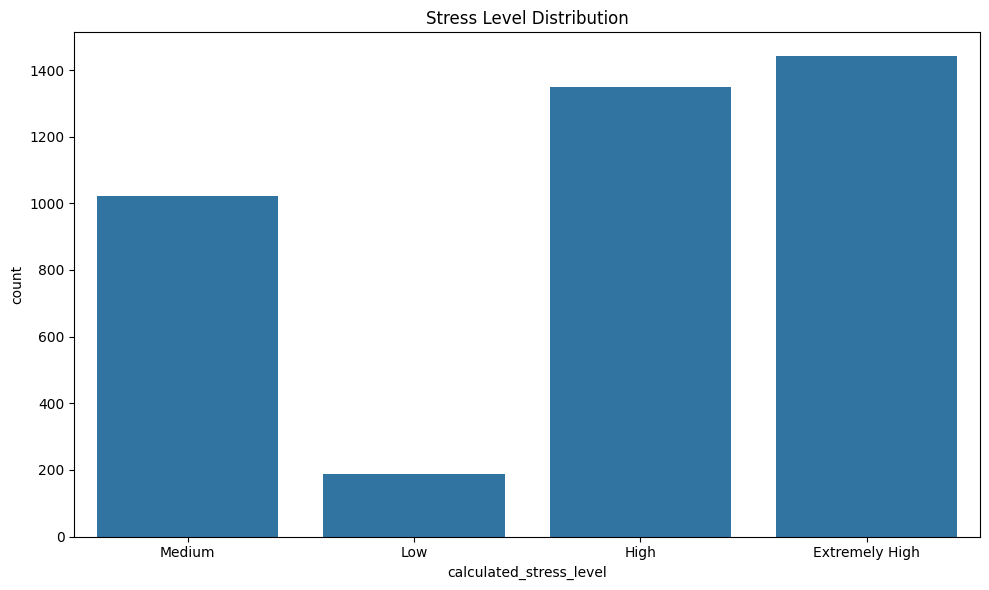

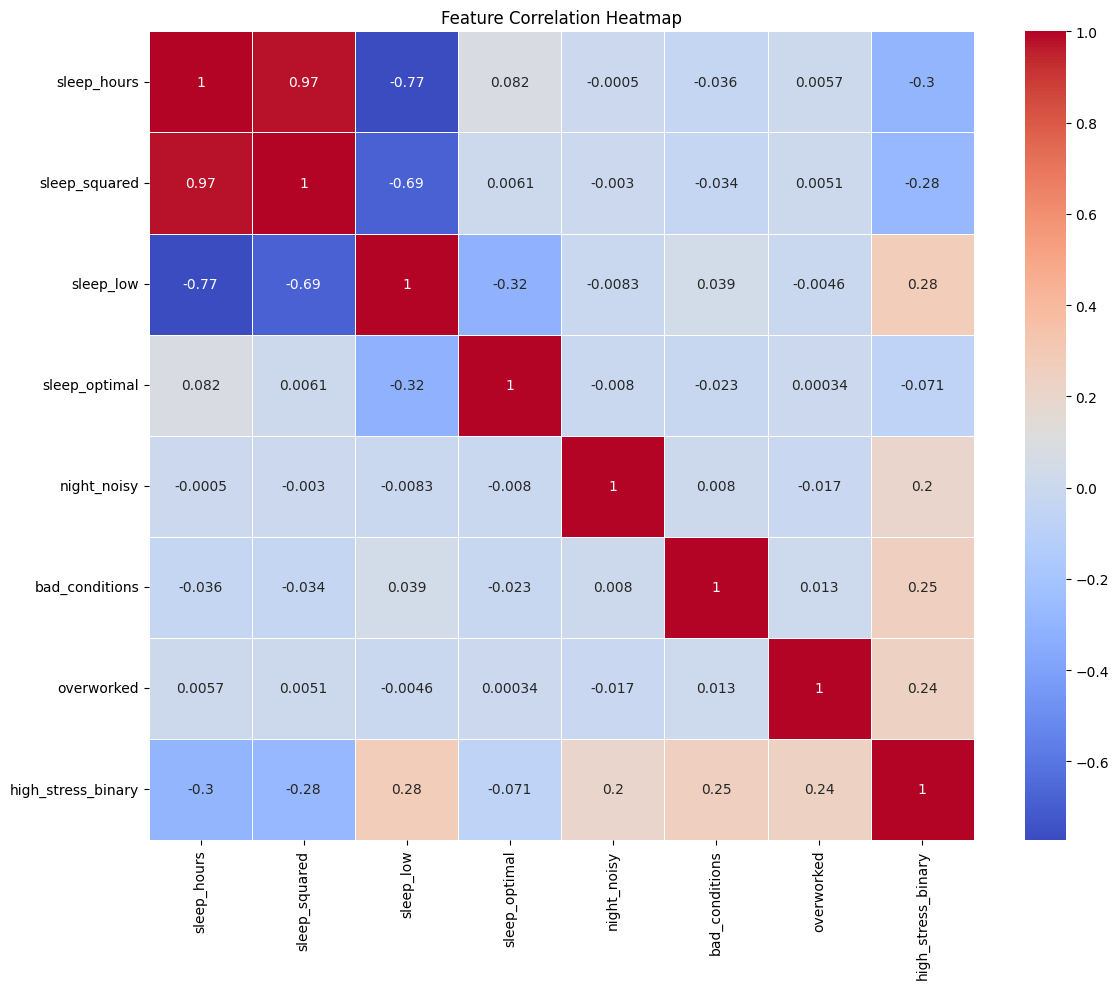

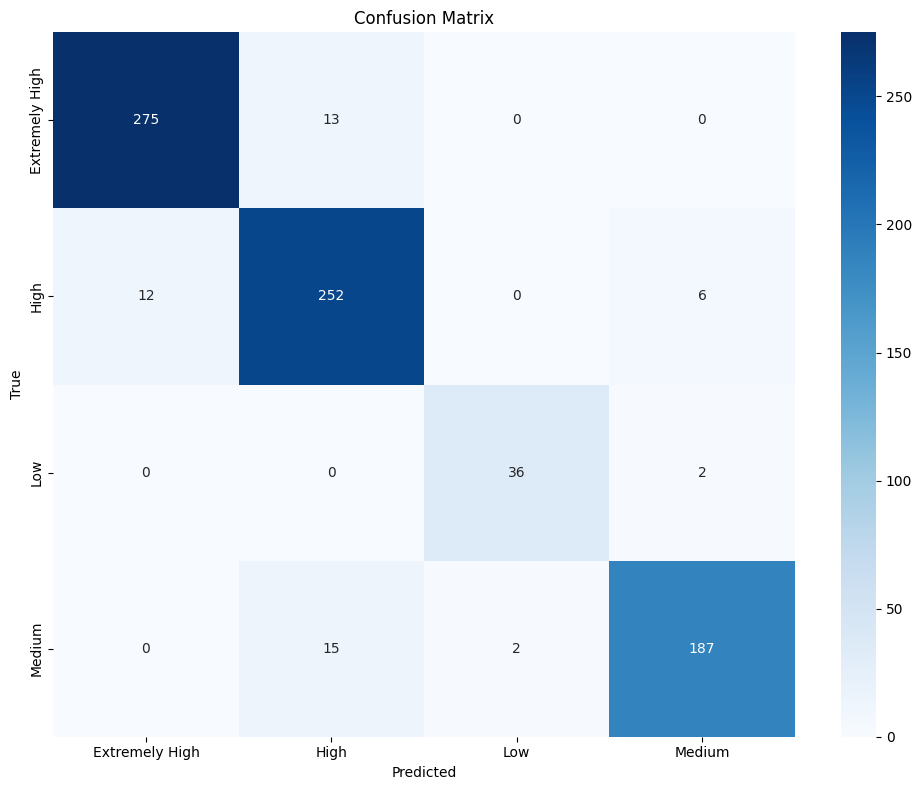

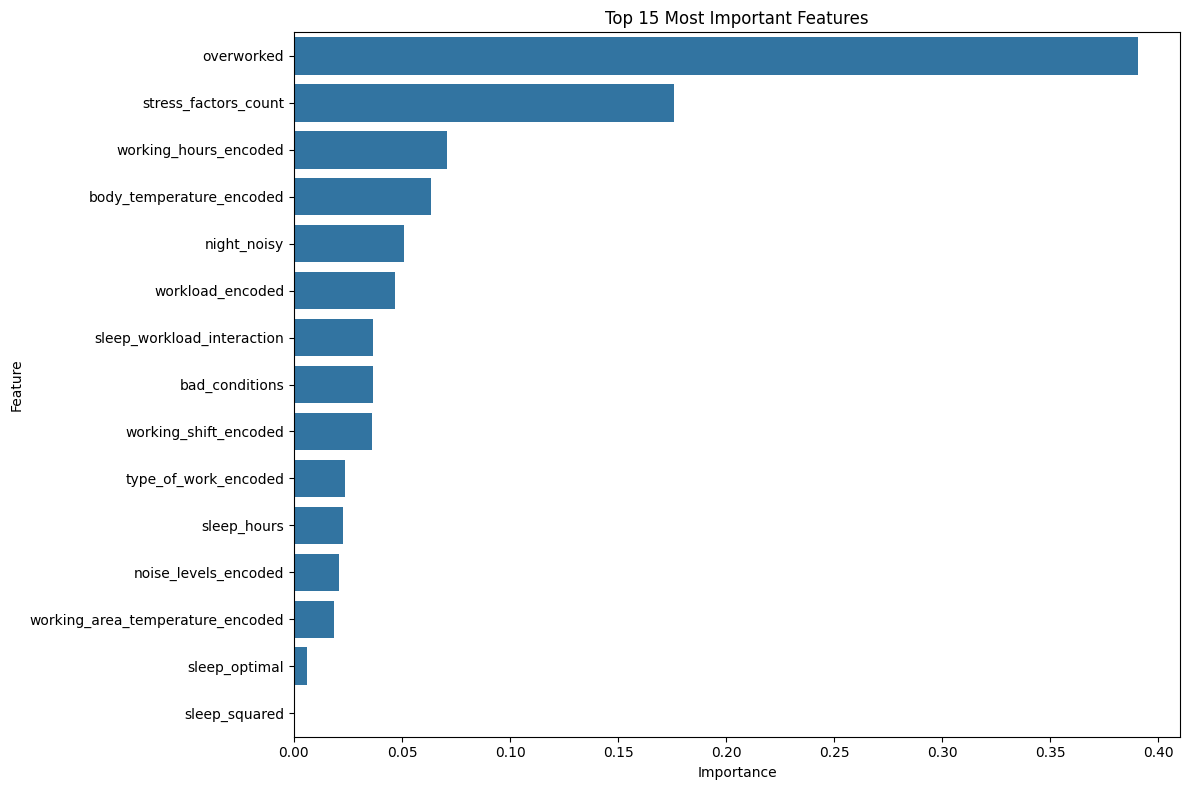

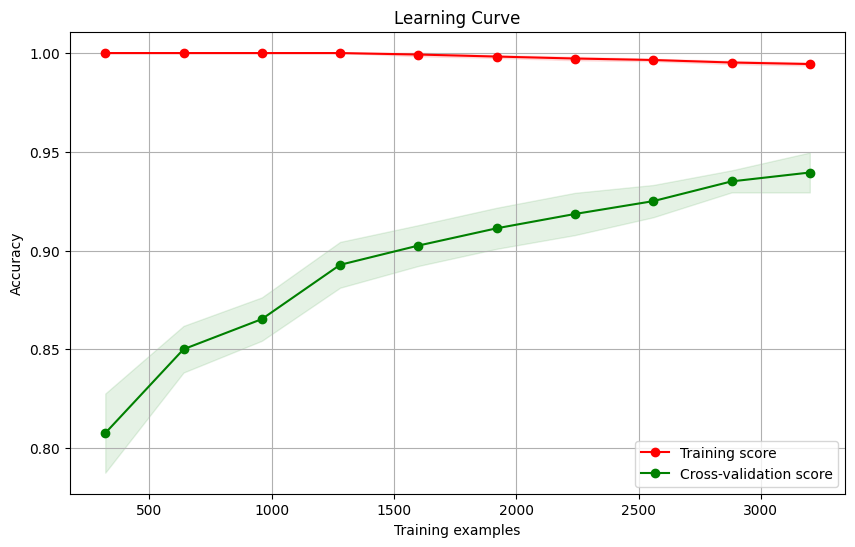

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

# 1. Load the dataset
print("Loading dataset...")
df = pd.read_csv('/content/workplace_stress_dataset_4k_dramatically_improved.csv')

# 2. Data exploration and preprocessing
print("\nDataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Check class distribution
print("\nTarget variable distribution:")
print(df['calculated_stress_level'].value_counts())
print(df['calculated_stress_level'].value_counts(normalize=True))

# 3. Data Visualization for better understanding
print("\nCreating visualizations for better understanding...")
plt.figure(figsize=(10, 6))
sns.countplot(x='calculated_stress_level', data=df)
plt.title('Stress Level Distribution')
plt.tight_layout()
plt.savefig('stress_distribution.png')

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
# Focus on numeric and binary features
correlation_columns = ['sleep_hours', 'sleep_squared', 'sleep_low', 'sleep_optimal',
                      'night_noisy', 'bad_conditions', 'overworked', 'high_stress_binary']
correlation_matrix = df[correlation_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

# 4. IMPROVED: Comprehensive Feature Engineering
print("\nPerforming advanced feature engineering...")

# 4.1 Utilize all engineered features present in the dataset
engineered_features = [
    'sleep_squared', 'sleep_low', 'sleep_optimal',
    'night_noisy', 'bad_conditions', 'overworked'
]

# 4.2 Create additional engineered features
# Interaction between sleep and workload
df['sleep_workload_interaction'] = df.apply(
    lambda row: 1 if (row['sleep_hours'] < 6 and row['workload'] == 'Heavy') else 0,
    axis=1
)

# Combined stress factors count
stress_conditions = [
    df['sleep_low'] == 1,
    df['working_shift'] == 'Night shift',
    df['workload'] == 'Heavy',
    df['noise_levels'] == 'Noisy',
    df['working_area_temperature'] == 'Uncomfortable',
    df['type_of_work'] == 'Demanding'
]
df['stress_factors_count'] = sum(stress_conditions)

# 5. Create dictionaries to store encoders and scalers
encoders = {}
scaler = StandardScaler()

# 6. Encode categorical variables
cat_columns = ['body_temperature', 'noise_levels', 'working_hours',
               'working_area_temperature', 'workload', 'type_of_work',
               'working_shift']

print("\nEncoding categorical variables...")
# Create a dictionary for categorical encodings (for interpretation)
cat_mappings = {}

for col in cat_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    encoders[col] = le

    # Store mappings for future reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    cat_mappings[col] = mapping
    print(f"Encoded {col}: {mapping}")

# 7. Encode target variable
print("\nEncoding target variable...")
target_encoder = LabelEncoder()
df['stress_level_encoded'] = target_encoder.fit_transform(df['calculated_stress_level'])
encoders['calculated_stress_level'] = target_encoder

# Create mapping for stress levels
stress_mapping = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
print(f"Stress level encoding: {stress_mapping}")

# 8. IMPROVED: Advanced feature preparation and scaling
print("\nPreparing and scaling features...")

# Define all numeric features including engineered ones
numeric_features = ['sleep_hours', 'sleep_squared', 'stress_factors_count']

# Scale all numeric features
for feature in numeric_features:
    if feature in df.columns:
        df[feature] = scaler.fit_transform(df[[feature]])

# 9. IMPROVED: Prepare comprehensive feature set
print("\nPreparing comprehensive feature set...")
encoded_columns = [col + '_encoded' for col in cat_columns]
binary_features = ['sleep_low', 'sleep_optimal', 'night_noisy',
                  'bad_conditions', 'overworked', 'sleep_workload_interaction']

# Combine all features
all_features = numeric_features + encoded_columns + binary_features
X = df[all_features]
y = df['stress_level_encoded']

print("\nFinal features used:", all_features)

# 10. IMPROVED: Split the data with stratification
print("\nSplitting data with stratification...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 11. IMPROVED: Hyperparameter tuning with cross-validation
print("\nPerforming hyperparameter tuning with cross-validation...")

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.8, 0.9, 1.0],
    'n_estimators': [100, 200]
}

# Use a smaller grid if you prefer faster execution
small_param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'n_estimators': [100, 200]
}

# Choose which grid to use (full grid will take longer but might yield better results)
use_full_grid = False  # Set to True for full hyperparameter search
selected_grid = param_grid if use_full_grid else small_param_grid

# Setup XGBoost classifier for tuning
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(target_encoder.classes_),
    random_state=42
)

# Create grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=selected_grid,
    cv=cv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Get best parameters and results
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# 12. IMPROVED: Train optimized XGBoost model
print("\nTraining optimized XGBoost model...")
best_model = grid_search.best_estimator_

# 13. IMPROVED: Evaluate model with detailed diagnostics
print("\nEvaluating model with detailed diagnostics...")
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized model accuracy: {accuracy:.4f}")

print("\nClassification report:")
report = classification_report(y_test, y_pred, target_names=target_encoder.classes_, output_dict=True)
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# 14. IMPROVED: Feature importance analysis with visualization
print("\nFeature importance analysis...")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png')

# 15. IMPROVED: Create an ensemble model for even better performance
print("\nCreating ensemble model for improved performance...")

# Define base models with different parameters
model1 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(target_encoder.classes_),
    learning_rate=0.05,
    max_depth=5,
    n_estimators=100,
    random_state=42
)

model2 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(target_encoder.classes_),
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    random_state=43
)

model3 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(target_encoder.classes_),
    learning_rate=0.01,
    max_depth=9,
    n_estimators=300,
    random_state=44
)

# Create voting ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb1', model1),
        ('xgb2', model2),
        ('xgb3', model3)
    ],
    voting='soft'  # Use probability estimates for voting
)

# Train ensemble
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble
ensemble_pred = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble model accuracy: {ensemble_accuracy:.4f}")

print("\nEnsemble classification report:")
print(classification_report(y_test, ensemble_pred, target_names=target_encoder.classes_))

# 16. IMPROVED: Learning curve analysis
print("\nGenerating learning curve analysis...")

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.savefig('learning_curve.png')

# 17. Save encoders, scaler, and mappings
print("\nSaving encoders and scaler...")
encoders_info = {
    'label_encoders': encoders,
    'numeric_scaler': scaler,
    'cat_mappings': cat_mappings,
    'stress_mapping': stress_mapping,
    'feature_columns': X.columns.tolist()
}

with open('workplace_stress_encoders_improved.pkl', 'wb') as f:
    pickle.dump(encoders_info, f)

# 18. Save the best model and ensemble
print("\nSaving optimized models...")
# Save individual model
with open('workplace_stress_xgboost_optimized.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save ensemble model
with open('workplace_stress_ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

print("\nDone! Optimized models and encoders saved successfully.")

# 19. IMPROVED: Sample prediction function with confidence scores
def predict_stress_level(sample_data, model_type='best'):
    """
    Make prediction with sample data.

    Args:
        sample_data: Dict with feature values
        model_type: 'best' for best single model, 'ensemble' for ensemble model

    Returns:
        Dict with prediction results and confidence scores
    """
    # Load encoders and model
    with open('workplace_stress_encoders_improved.pkl', 'rb') as f:
        encoders_info = pickle.load(f)

    if model_type == 'best':
        with open('workplace_stress_xgboost_optimized.pkl', 'rb') as f:
            loaded_model = pickle.load(f)
    else:
        with open('workplace_stress_ensemble_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)

    # Process input data
    sample_df = pd.DataFrame([sample_data])

    # Create engineered features
    sample_df['sleep_squared'] = sample_df['sleep_hours'] ** 2
    sample_df['sleep_low'] = (sample_df['sleep_hours'] < 6).astype(int)
    sample_df['sleep_optimal'] = ((sample_df['sleep_hours'] >= 7) &
                                 (sample_df['sleep_hours'] <= 8)).astype(int)

    sample_df['night_noisy'] = ((sample_df['working_shift'] == 'Night shift') &
                               (sample_df['noise_levels'] == 'Noisy')).astype(int)

    sample_df['bad_conditions'] = ((sample_df['working_area_temperature'] == 'Uncomfortable') &
                                  (sample_df['type_of_work'] == 'Demanding')).astype(int)

    sample_df['overworked'] = ((sample_df['workload'] == 'Heavy') &
                              (sample_df['working_hours'].isin(['Long Day', 'Extreme Overtime']))).astype(int)

    sample_df['sleep_workload_interaction'] = sample_df.apply(
        lambda row: 1 if (row['sleep_hours'] < 6 and row['workload'] == 'Heavy') else 0,
        axis=1
    )

    # Count stress factors
    stress_conditions = [
        sample_df['sleep_low'] == 1,
        sample_df['working_shift'] == 'Night shift',
        sample_df['workload'] == 'Heavy',
        sample_df['noise_levels'] == 'Noisy',
        sample_df['working_area_temperature'] == 'Uncomfortable',
        sample_df['type_of_work'] == 'Demanding'
    ]
    sample_df['stress_factors_count'] = sum(stress_conditions)

    # Scale numeric features
    for feature in ['sleep_hours', 'sleep_squared', 'stress_factors_count']:
        if feature in sample_df.columns:
            sample_df[feature] = encoders_info['numeric_scaler'].transform(sample_df[[feature]])

    # Encode categorical features
    for col in encoders_info['cat_mappings'].keys():
        le = encoders_info['label_encoders'][col]
        sample_df[col + '_encoded'] = le.transform(sample_df[col])

    # Select features in correct order
    X_sample = sample_df[encoders_info['feature_columns']]

    # Make prediction with probabilities
    if hasattr(loaded_model, 'predict_proba'):
        pred_proba = loaded_model.predict_proba(X_sample)[0]
        pred_encoded = loaded_model.predict(X_sample)[0]
    else:
        # Some ensemble methods might not have predict_proba
        pred_encoded = loaded_model.predict(X_sample)[0]
        pred_proba = [0] * len(encoders_info['label_encoders']['calculated_stress_level'].classes_)
        pred_proba[pred_encoded] = 1.0

    # Decode prediction
    pred_label = encoders_info['label_encoders']['calculated_stress_level'].inverse_transform([pred_encoded])[0]

    # Get confidence scores for all classes
    confidence_scores = {}
    for i, label in enumerate(encoders_info['label_encoders']['calculated_stress_level'].classes_):
        confidence_scores[label] = float(pred_proba[i])

    return {
        'stress_level': pred_label,
        'stress_level_encoded': int(pred_encoded),
        'confidence': confidence_scores,
        'top_confidence': float(pred_proba[pred_encoded])
    }

# Example usage of improved prediction function
print("\nTesting improved prediction function with sample data...")
sample_data = {
    'sleep_hours': 4.5,  # Low sleep
    'body_temperature': 'Not Normal',
    'noise_levels': 'Noisy',
    'working_hours': 'Long Day',
    'working_area_temperature': 'Uncomfortable',
    'workload': 'Heavy',
    'type_of_work': 'Demanding',
    'working_shift': 'Night shift'
}

# Try with best single model
prediction = predict_stress_level(sample_data, 'best')
print(f"Best model predicted stress level: {prediction['stress_level']}")
print(f"Confidence: {prediction['top_confidence']:.4f}")

# Try with ensemble model
ensemble_prediction = predict_stress_level(sample_data, 'ensemble')
print(f"Ensemble model predicted stress level: {ensemble_prediction['stress_level']}")
print(f"Confidence: {ensemble_prediction['top_confidence']:.4f}")

# Print confidence for all classes
print("\nConfidence scores for all stress levels:")
for level, score in prediction['confidence'].items():
    print(f"{level}: {score:.4f}")